













































# Lab 2: Logistic regression - Titanic

https://www.kaggle.com/c/titanic/data

In [663]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [664]:
import sklearn as sk

In [665]:
filename = 'titanic'

from urllib.request import urlretrieve
urlretrieve("https://bianchi.wp.imt.fr/files/2023/12/titanic.zip", filename + '.zip')

import os
zip_file = os.path.join(os.getcwd(), 'titanic.zip')

import zipfile
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

In [666]:
df = pd.read_csv("traintitanic.csv")

In [667]:
# Using head(), info(), describe() etc. inspect the dataset. Which features are numerical, which ones are categorical? Comment about missing data.
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Such data as "Survived", "Pclass", "Sex", "Embarked" are categorical. The "Cabin" column can be transformed to categorical if we just leave the first letter (which probably identifies the part of the ship) and remove the numbers, which are unique.

Columns like "Age", "SibSp"(amount of siblings+spouses), "Parch" (amount of parents+children), "Fare" are numerical.

In [668]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are some missing values in columns "Age", "Cabin", "Embarked"

In [669]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [670]:
# Using the df.groupby("Pclass"), comment about the nature of the passengers as a function of the class ticket (first, second or third class)
df.groupby("Pclass").mean()

<ipython-input-670-80b3c51c2758>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("Pclass").mean()


,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


People payed more for higher class of tickets. Those staying in 3rd class on average had more family members with them on a trip.

And most important, people in 1st class had 63% chance of survival (higher than average), those in 2nd class - 47%, 3rd - 24%. Also, 1st class passengers tend to be older.

<Axes: >

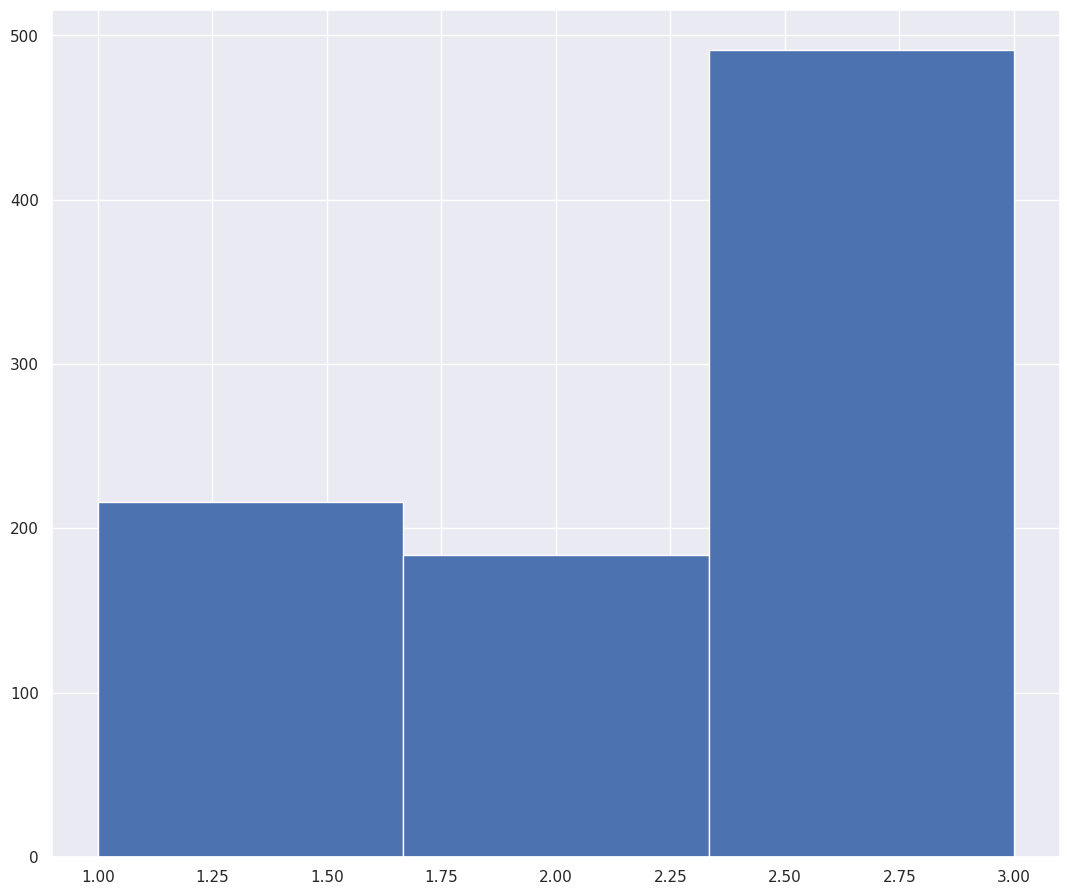

In [671]:
# Plot the histogram of Passenger's classes
df["Pclass"].hist(bins=3)

We see that most of the people stayed in the 3rd class.


In [672]:
# Comment about the impact of the sex of passengers
df.groupby("Sex").mean()

<ipython-input-672-39ad7f91a4f9>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("Sex").mean()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893


We see a very strong correlation between sex and survival rate. Females had survival rate of 74%, which is much higher than average. Also they tend to stay in better class (2.15 < 2.4).

Their higher survival rate can be connected not only to the sex. It can be due to the fact that they lived in better classes of rooms, which maybe had quicker access to emergency exits, and dinghies. We will investigate this further.

In [673]:
# Comment about the impact of the embarkation city. How do you explain the discrepancies in survival rate?
df.groupby("Embarked").mean()

<ipython-input-673-751376c3c3a4>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("Embarked").mean()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Embarked,,,,,,,
C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030
S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812


We see that people who embarked at Cherbourg had a higher-than-average survival rate. A possible explanation for this is that people who embarked at C on average had a higher cabin class, which improved their chance of survival.

<Axes: >

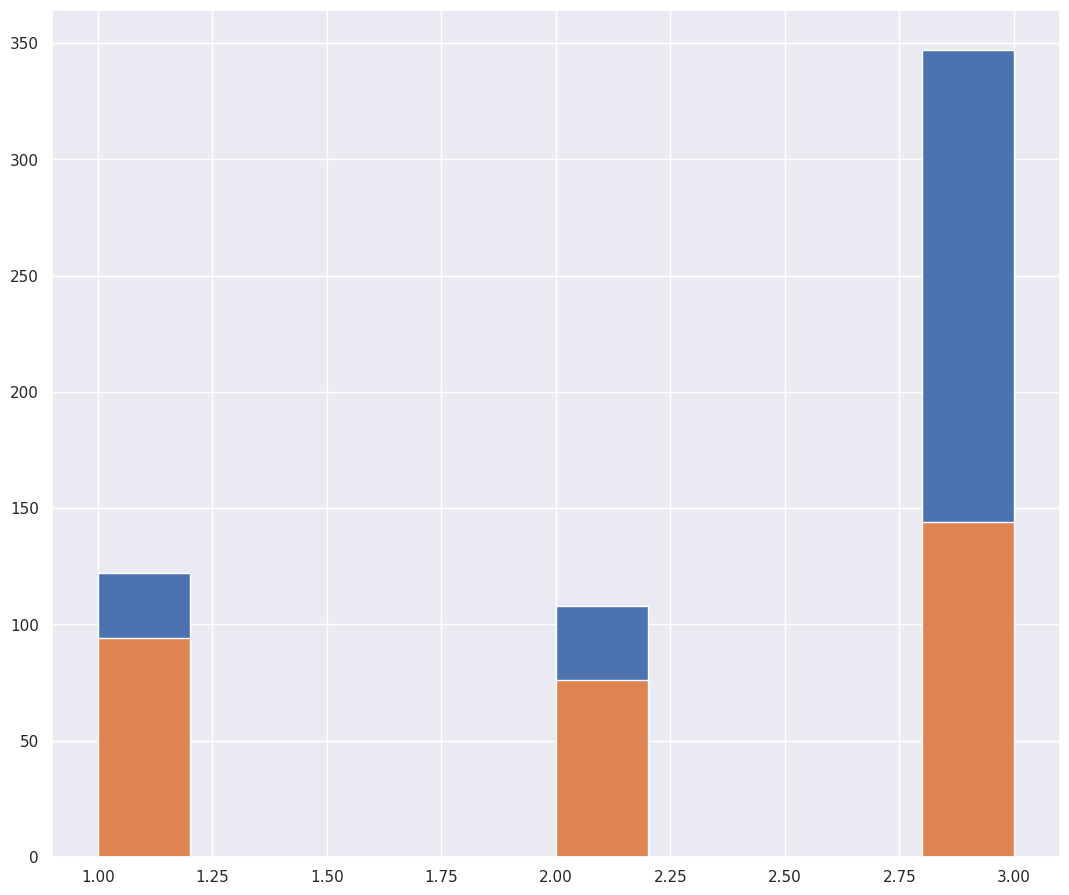

In [674]:
#Plot the histogram of the number of men in each class. Do the same for men. Comment.
df[df["Sex"]=="male"].Pclass.hist()
df[df["Sex"]=="female"].Pclass.hist()

We see that 1st and 2nd classes are primarily consisted of women (orange). This could explain why women had better chance of survival.

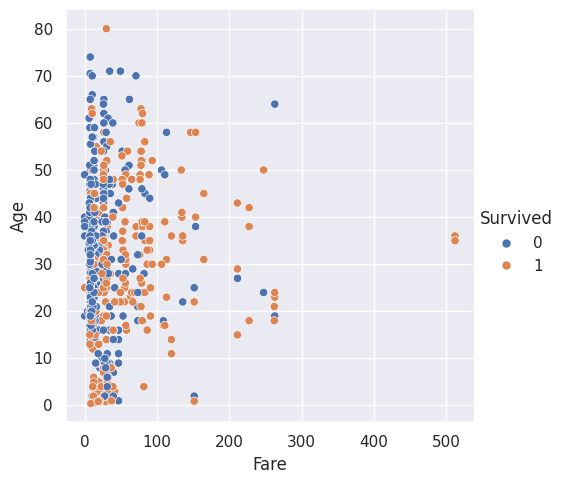

In [675]:
# Comment briefly the following code
sns.relplot(data=df,x="Fare", y="Age",hue="Survived")

Among people with higher fare, a lot of them survived. However, there are still a lot of survivors among lower rate tickets.

In [676]:
# In case you believe that other plots are interesting to vizualize the data set, you can provide them here.
df["Cabin_area"] = df["Cabin"].apply(lambda x: x[:1] if not pd.isna(x) else "N")

df.groupby("Cabin_area").mean()

<ipython-input-676-03b6893d0638>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("Cabin_area").mean()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Cabin_area,,,,,,,
A,439.600000,0.466667,1.000000,44.833333,0.133333,0.133333,39.623887
B,521.808511,0.744681,1.000000,34.955556,0.361702,0.574468,113.505764
C,406.440678,0.593220,1.000000,36.086667,0.644068,0.474576,100.151341
D,475.939394,0.757576,1.121212,39.032258,0.424242,0.303030,57.244576
E,502.437500,0.750000,1.312500,38.116667,0.312500,0.312500,46.026694
F,370.384615,0.615385,2.384615,19.954545,0.538462,0.538462,18.696792
G,216.000000,0.500000,3.000000,14.750000,0.500000,1.250000,13.581250
N,443.208151,0.299854,2.639010,27.555293,0.547307,0.365357,19.157325
T,340.000000,0.000000,1.000000,45.000000,0.000000,0.000000,35.500000


In [677]:
df["Cabin_area"].value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_area, dtype: int64

We can notice that first letter of cabin could be really useful. For example people in areas "B", "D", and "E" had very high survival rates (more than 70%)

Also we can notice that usually the cabin records are present for 1st class passengers. NaN values in this value go together with 2-3rd classes.

Also, there is only 1 value for T, so it may be better to join T to the A (since they have other features, like age, and fare similar).

In [678]:
print(df.loc[df["Cabin_area"] == "T"])
df.at[339, "Cabin_area"] = "A"

     PassengerId  Survived  Pclass                          Name   Sex   Age  \
339          340         0       1  Blackwell, Mr. Stephen Weart  male  45.0   

     SibSp  Parch  Ticket  Fare Cabin Embarked Cabin_area  
339      0      0  113784  35.5     T        S          T  


# Categorical encoding

Certain columns (sex, embarked, etc.) are categorical. We need to transform them into numerical features.

In [679]:
# Create a new column "Sex_num" where the strings "male" and "female" are replaced by a binary integer.
df["Sex_num"] = (df["Sex"]=="male").astype("int") #That's ok because there is no missing data in the "Sex" column

In [680]:
# What is the following code doing?
pd.get_dummies(df['Embarked'])

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
886,0,0,1
887,0,0,1
888,0,0,1
889,1,0,0


This transformed our categorical data into 3 columns with values 0/1. This is useful, as now we deal with numbers instead of letters C, Q, S

In [681]:
# Using pd.get_dummies, create new columns in the dataframe df, one for each embarkation port
ports = pd.get_dummies(df['Embarked'], prefix="port") # adding prefix, so it's not confused with cabin letters
df = df.assign(**ports)

In [682]:
# We may drop the two columns "Sex" and "Embarked", as we now included their onehot counterparts in the dataframe. Check that the following code drops theses columns
df.drop(columns=["Sex","Embarked"], inplace=True)

In [683]:
# Use df.head(). Did the dropped column disappear? Solve possible issued using the argument inplace=True, in the drop method
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Cabin_area,Sex_num,port_C,port_Q,port_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,N,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,N,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,C,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,N,1,0,0,1


Thanks to using in_place, dataframe got directly modified, and columns are dropped.

In [684]:
# we also need to transform categorical data for cabin letters
cabin_letters = pd.get_dummies(df['Cabin_area'], prefix="cabin") # adding prefix, so it's not confused with port letters
df = df.assign(**cabin_letters)
df.drop(columns=["Cabin_area", "Cabin", "cabin_N"], inplace=True) #dropping "cabin_N" as well, which standed for missing data case.

In [685]:
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Sex_num', 'port_C', 'port_Q', 'port_S', 'cabin_A',
       'cabin_B', 'cabin_C', 'cabin_D', 'cabin_E', 'cabin_F', 'cabin_G'],
      dtype='object')


<ipython-input-686-10a0885909cb>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df[corr_columns].corr(),annot=True)


<Axes: >

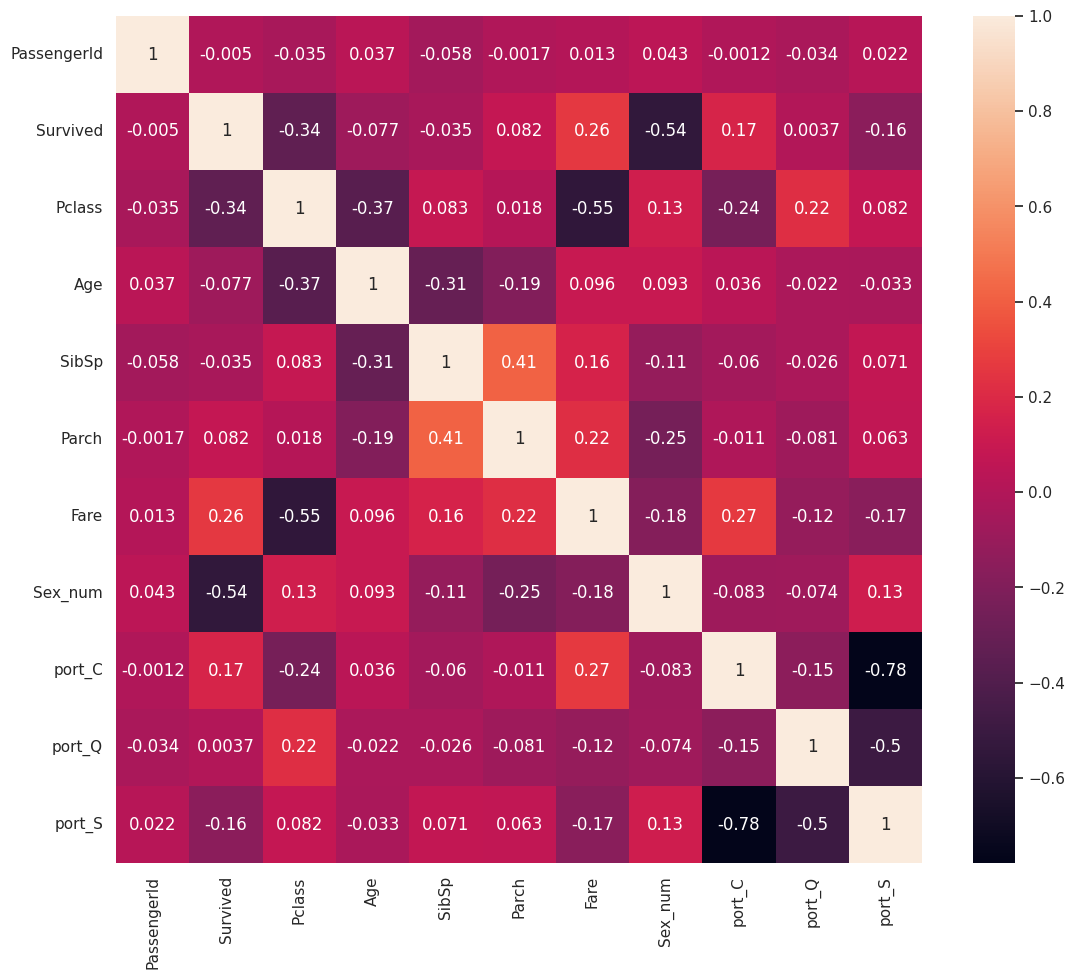

In [686]:
# What does the matrix df.corr() represent? Provide your interpretation of the numbers you see.
sns.set(rc = {'figure.figsize':(13,11)})
corr_columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Sex_num', 'port_C', 'port_Q', 'port_S'] #not plotting cabin columns, because they will make the graph messy
sns.heatmap(df[corr_columns].corr(),annot=True)

This matrix represent the correlation of each pair of features. Basically correlation shows us how growth of one parameter would impact the other parameter. For example, correlation of "Fare" and "Survived" of 0.26 tells us, that people who have payed higher fare had bigger survival rate.
Correlation coefficients close to 0 imply no correlation. The ones close to -1 or 1 imply strong correlation


We see high correlation of survival with sex, fare, class, and port of embarkment. Interstingly, there is a low correlation between survival rate and age.

# Data cleansing
Check the number of missing values in "Age". You can either


*   Do nothing (the rows with missing "Age" will be ignored in the training stage)
*   Or fill the missing values with some value of your choice.


Do something smart.



In [687]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Sex_num      891 non-null    int64  
 10  port_C       891 non-null    uint8  
 11  port_Q       891 non-null    uint8  
 12  port_S       891 non-null    uint8  
 13  cabin_A      891 non-null    uint8  
 14  cabin_B      891 non-null    uint8  
 15  cabin_C      891 non-null    uint8  
 16  cabin_D      891 non-null    uint8  
 17  cabin_E      891 non-null    uint8  
 18  cabin_F      891 non-null    uint8  
 19  cabin_G 

We see that there are 117 missing values for age.

Age is the most correlated with PClass, so we can use the PClass value to estimate the age for missing values.

In [688]:
# Do something smart to handle the problem of missing values in the "Age" column
mean_age_by_class = df.groupby("Pclass")["Age"].mean() # mean age of passengers in each class
df["Age"] = df[["Age", "Pclass"]].apply(lambda x: mean_age_by_class[x[1]] if pd.isna(x[0]) else x[0], axis=1)

In [689]:
# We will train a logistic regression. Write below the columns which you would like to keep as features for logistic regression.
# n.b.: We will NOT keep the columns Ticket and Cabin. Why?

mycolumns = ["Pclass", "Fare", "Sex_num", "port_C", "port_S", "port_Q", "Age", "SibSp", "Parch", 'cabin_A',
       'cabin_B', 'cabin_C', 'cabin_D', 'cabin_E', 'cabin_F', 'cabin_G']

Ticket number is completely random value, which has nothing to do with survival. As for cabin column, i decided to include the first letter from the cabin number.


In [690]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaled = scaler.fit_transform(df[mycolumns].to_numpy())
df[mycolumns] = pd.DataFrame(scaled, columns=mycolumns)

Here we use min-max scaler to bring all the selected columns to the same scale [0,1]

#Logistic regression


In [691]:
# Train a logistic regression classifier using sklearn, based on the above dataframe and the chosen columns.
# Explain the meaning of the parameter in the logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2',C=1.0,max_iter=1000,)

Meaning of the parameter "l2" is that ridge regularization is used.

C is the hyperparameter, which controls the strength of regularization. Smaller C means stronger regularization.

max_iter specifies the maximum number of iterations done during solving.

In [692]:
# Fit the model
lr.fit(df[mycolumns], df["Survived"])

LogisticRegression(max_iter=1000)

In [693]:
# Display the coefficients of the logistic regression. Discuss the possible positive/negative impact on survival of certain parameters
print([mycolumns[i]+": {0:0.3f}".format(float(lr.coef_[0][i])) for i in range(len(lr.coef_[0]))])

['Pclass: -1.798', 'Fare: 0.484', 'Sex_num: -2.561', 'port_C: 0.151', 'port_S: -0.328', 'port_Q: -0.012', 'Age: -2.288', 'SibSp: -1.459', 'Parch: -0.424', 'cabin_A: 0.216', 'cabin_B: 0.420', 'cabin_C: -0.014', 'cabin_D: 0.761', 'cabin_E: 1.127', 'cabin_F: 0.885', 'cabin_G: -0.262']


As was discussed previously, Pclass has negative impact on survival (people in 1st class tend to survive more than those in the 2nd and 3rd class)

Fare has positive impact. Since higher class tends to cost more, this is similar to the previous point.

Before we observed very small correlation of age and survival rate. Interstingly, the corresponding parameter of age is relatively substantial. It's negative, meaning that older people survive less.

Also, we see that males (encoded with 1) tend to survive less.

# Performance evaluation


In [694]:
# Load the test data
Xtest = pd.read_csv("testtitanic.csv")
ytest = pd.read_csv("gender_submission.csv")
dftest = pd.merge(Xtest,ytest)

In [695]:
# Process the test features in order to obtain the same format as for the train set
# filling the age column
mean_age_by_class2 = dftest.groupby("Pclass")["Age"].mean()
dftest["Age"] = dftest[["Age", "Pclass"]].apply(lambda x: mean_age_by_class2[x[1]] if pd.isna(x[0]) else x[0], axis=1)

#doing onehot encoding for categorical data
dftest["Sex_num"] = (dftest["Sex"]=="male").astype("int")
ports = pd.get_dummies(dftest['Embarked'], prefix="port")
dftest = dftest.assign(**ports)

dftest["Cabin_area"] = dftest["Cabin"].apply(lambda x: x[:1] if not pd.isna(x) else "N")
cabin_letters = pd.get_dummies(dftest['Cabin_area'], prefix="cabin") # adding prefix, so it's not confused with port letters
dftest = dftest.assign(**cabin_letters)

# scaling the test data the same way we scaled training data.
scaler = preprocessing.MinMaxScaler()
scaled = scaler.fit_transform(dftest[mycolumns].to_numpy())
dftest[mycolumns] = pd.DataFrame(scaled, columns=mycolumns)

In [696]:
# Define a dataframe with only the columns you want to keep (and the label)
dftest=dftest[mycolumns+["Survived"]]

In [697]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Fare      417 non-null    float64
 2   Sex_num   418 non-null    float64
 3   port_C    418 non-null    float64
 4   port_S    418 non-null    float64
 5   port_Q    418 non-null    float64
 6   Age       418 non-null    float64
 7   SibSp     418 non-null    float64
 8   Parch     418 non-null    float64
 9   cabin_A   418 non-null    float64
 10  cabin_B   418 non-null    float64
 11  cabin_C   418 non-null    float64
 12  cabin_D   418 non-null    float64
 13  cabin_E   418 non-null    float64
 14  cabin_F   418 non-null    float64
 15  cabin_G   418 non-null    float64
 16  Survived  418 non-null    int64  
dtypes: float64(16), int64(1)
memory usage: 58.8 KB


We see that there are some missing values.

In [698]:
# Check if there are some missing values. If needed, row containing missing values can be dropped using the dropna() method (inplace)
dftest.dropna(inplace=True)

In [700]:
# Compute the hard predictions on the test set (using only the columns to keep)
y_pred = lr.predict(dftest[mycolumns])

In [701]:
# Compute the accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(dftest["Survived"], y_pred)

0.9496402877697842

In [702]:
# Compute the soft predictions unsing predict_proba
lr.predict_proba(dftest[mycolumns])

array([[0.89670269, 0.10329731],
       [0.61678008, 0.38321992],
       [0.8899438 , 0.1100562 ],
       [0.90458728, 0.09541272],
       [0.44121528, 0.55878472],
       [0.86489255, 0.13510745],
       [0.36932467, 0.63067533],
       [0.82207631, 0.17792369],
       [0.25725076, 0.74274924],
       [0.91821255, 0.08178745],
       [0.89662974, 0.10337026],
       [0.73271151, 0.26728849],
       [0.07327946, 0.92672054],
       [0.9310214 , 0.0689786 ],
       [0.07589604, 0.92410396],
       [0.16587558, 0.83412442],
       [0.78126999, 0.21873001],
       [0.83073702, 0.16926298],
       [0.46795501, 0.53204499],
       [0.43887435, 0.56112565],
       [0.72151926, 0.27848074],
       [0.85302061, 0.14697939],
       [0.15304635, 0.84695365],
       [0.44747895, 0.55252105],
       [0.09190288, 0.90809712],
       [0.95770972, 0.04229028],
       [0.04060593, 0.95939407],
       [0.83700543, 0.16299457],
       [0.65413373, 0.34586627],
       [0.88424314, 0.11575686],
       [0.

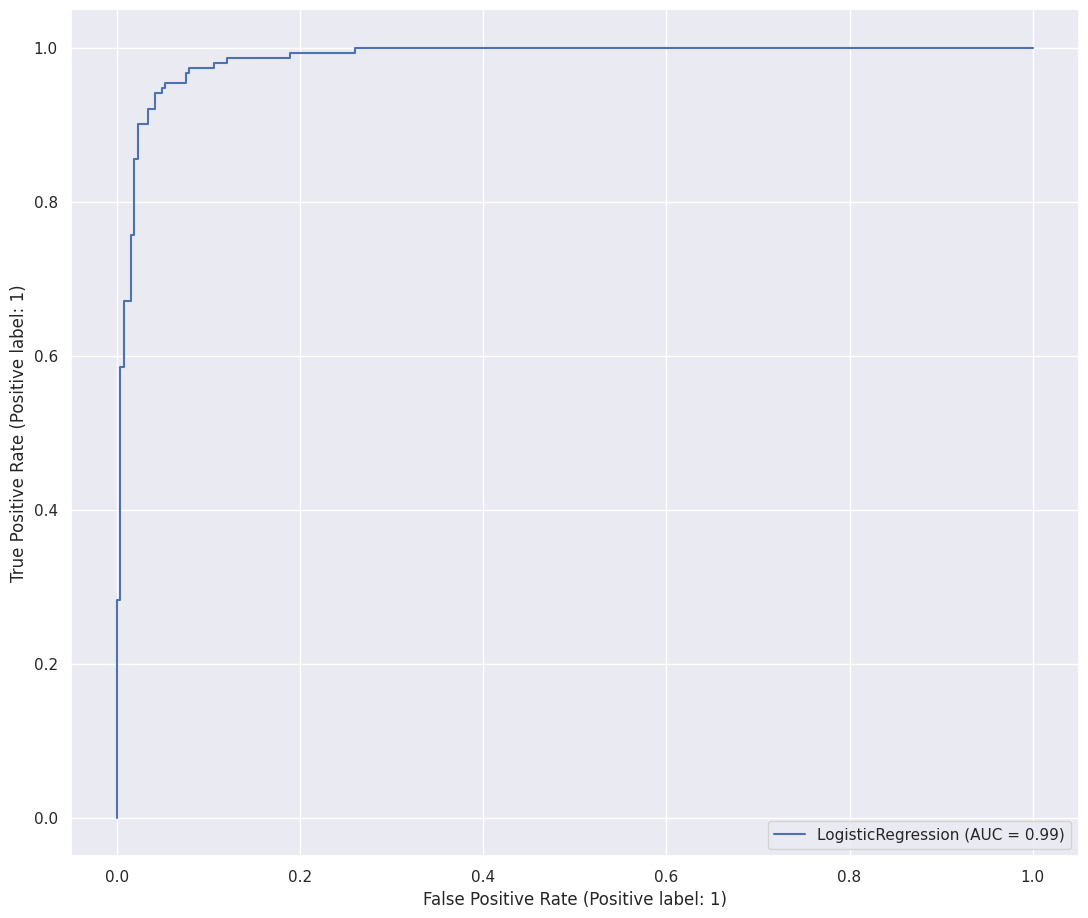

In [703]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(lr, dftest[mycolumns], dftest.Survived)

Final thoughts:

I have tried adding Min Max scaler, to bring all the features to the same range, and it helped to improve accuracy score.

I also have tried adding the additional features, utilizing the first letter of the cabin. Even though letters like "B", "C" had high correlation with survival rate, they didn't improve much the accuracy score. However, I decided to leave it, and I would appreciate any feedback for improvement!

# Bonus question: do whatever you find useful

Here are some examples:

*   Try to include useful elements of the Cabin number
*   Try different regularization parameters
* Try L1 regularization instead of ridge
* Try linear regression



